In [1]:
# Packages
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt

# Atmosphere parameters
Cn2_h0 = 1e-17       # baseline Cn^2 [m^(-2/3)] (weak: 1e-17, strong: 1e-12)
V = 23           # visibility [km]
vG = 5.0            # ground wind [m/s] (weak: 5, strong: 10)
vT = 20.0            # tropopause wind [m/s] (weak: 20, strong: 30)
HT = 10000.0         # tropopause height [m]
LT = 1000.0          # tropopause thickness [m]
M = 1                # turbulence scaling
RE = 6370e3          # Earth radius [m]
L0 = 50              # turbulence outer scale (100-50) [m] (size of largest eddies)
phi = np.deg2rad(90)    # angle between the wind direction and the zenith

# Satellite parameters
h = 300e3            # satellite altitude [m]
zeta = np.deg2rad(30)  # zenith angle

# Receiver parameters 
hg = 100             # ground elevation above sea level [m]
aR = 0.35           # aperture radius [m]
b = (1/3)*aR         # field stop radius [m]
eta_QE = 0.7         # detector quantum efficiency
k0 = 2*np.pi / L0

# Candidate operational parameters 
lambdas = [810e-9, 1064e-9, 1550e-9]    # wavelengths [nm] (lambda)
beam_waists = [0.005, 0.05, 0.1]        # initial beam waists [m] (w0)
station_heights = [0, 10, 20]           # ground station heights [m] (h)

In [2]:
# Kim model 
def p_func(V):
    """Gives the exponent p in the Kim model based on visibility V [km]"""
    if V > 50: return 1.6
    elif 6 <= V <= 50: return 1.3
    elif 1 <= V < 6: return 0.16 * V + 0.34
    elif 0.5 <= V < 1: return V - 0.5
    elif V < 0.5: return 0
    else: return 1.3

# Wind velocity profile
def v_profile(hh, zeta):
    bracket = np.sqrt(np.sin(phi)**2 + (np.cos(phi)**2) * (np.cos(zeta)**2))
    return vG + vT * np.exp(-(((hh + hg) * np.cos(zeta) - HT) / LT)**2) * bracket

# Refractive index structure parameter model (Stotts et al. 2023)
def Cn2_profile(hh, lam, w0, h0):
    vhh = v_profile(hh, zeta)
    term1 = 1.04e-3 * (9.0 / vhh)**2 * ((hh + hg)/1e5)**10 * np.exp(-(hh+hg)/1200.0)
    term2 = 2.7e-16 * np.exp(-(hh+hg)/1700.0)
    term3 = Cn2_h0 * (h0 / (hh + 1e-9))**(4/3)
    return M * (term1 + term2) + term3

In [3]:
# Efficiency component functions
def eta_weather(gamma, L_atm): 
    """Gives the transmittance of the atmosphere based on the attenuation coefficient gamma and the slant path"""
    return np.exp(-gamma * L_atm)

def eta_lt(aR, wLT, b): 
    """Gives the efficiency due to light truncation at the receiver aperture"""    
    return np.exp(-2 * b**2 / (wLT**2)) - np.exp(-2 * aR**2 / (wLT**2))

def strehl_ratio(aR, r0):
    DR = 2*aR # Receiver diameter
    return (1 + (DR/r0)**(5/3))**(-6/5) # r0 is Fried parameter defined below

# Coupling efficiency according to the model in Jovanovic et al 2017
def eta_coupling_strehl(aR, r0):
    return (74*strehl_ratio(aR, r0)+1.84)/100

# Total transmittance (efficiency)
def eta_tot(gamma, L_atm, aR, wLT, b, eta_QE, r0): 
    return (eta_weather(gamma,L_atm) *
            eta_lt(aR,wLT, b) *
            eta_coupling_strehl(aR,r0) *
            eta_QE)

In [4]:
# Main calculation function

def evaluate(lam, w0, h0):
    k = 2 * np.pi / lam

    # Atmospheric attenuation
    p = p_func(V)
    gamma = ((3.91 / V) * (lam * 1e9 / 550) ** (-p)) / 1000.0  # [1/m]

    # Slant lengths
    L = np.sqrt((RE + h)**2 + (RE + h0)**2 * (np.cos(zeta)**2 - 1)) - (RE + h0) * np.cos(zeta)
    L_atm = np.sqrt((RE + HT)**2 + (RE + h0)**2 * (np.cos(zeta)**2 - 1)) - (RE + h0) * np.cos(zeta)

    # Beam diffraction
    w_L = w0 * np.sqrt(1 + (lam * L / (np.pi * w0**2))**2)

    # Rytov variance (integral form)
    integral_Ry2, _ = quad(lambda hh: (hh - h0)**(5/6) * Cn2_profile(hh, lam, w0, h0), h0, HT)
    sigma_Ry2 = 2.25 * (2*np.pi/lam)**(7/6) * (1/np.cos(zeta))**(11/6) * integral_Ry2

    # Scintillation index
    sigma_I2 = np.exp(
        (0.49 * sigma_Ry2) / (1 + 1.11 * sigma_Ry2**(12/5))**(7/6)
        + (0.51 * sigma_Ry2) / (1 + 0.69 * sigma_Ry2**(12/5))**(5/6)
    ) - 1

    # Beam broadening (turbulence + diffraction)
    Lambda = 2*L / (k * w_L**2)
    w_LT = w_L * np.sqrt(1 + 1.63 * (sigma_Ry2**(6/5)) * Lambda)

    # Beam wander (diffraction limited)
    RL = L * (1 + (np.pi * w0**2 / (lam * L))**2)
    Omega = 1 - L / RL

    # Beam wander variance (due to turbulence)
    def f_xi(xi): 
        return (Omega + (1 - Omega) * xi)**2 + 1.63 * (sigma_Ry2**(6/5)) * Lambda * (1 - xi)**(16/5)
    
    def integrand_tb(xi):
    	return xi**2 * ( 1 / f_xi(xi)**(1/6) - (k0**(1/3) * w0**(1/3)) / (1 + (k0**2) * (w0**2) * f_xi(xi))**(1/6) ) 
    integral_tb, _ = quad(integrand_tb, 0, 1)     
    sigma_tb2 = 7.25 * Cn2_profile(HT, lam, w0, h0) * (w0**(-1/3)) * (L_atm**3) * integral_tb

    # Fried parameter
    integral_r0, _ = quad(lambda hh: Cn2_profile(hh, lam, w0, h0), h0, HT)
    r0 = (0.423 * k**2 * (1/np.cos(zeta)) * integral_r0)**(-3/5)

    # Isoplanatic angle
    integral_theta0, _ = quad(lambda hh: Cn2_profile(hh, lam, w0, h0) * hh**(5/3), h0, HT)
    theta0 = (2.914 * k**2 * (1/np.cos(zeta))**(8/3) * integral_theta0)**(-3/5)

    # Coherence time
    num, _ = quad(lambda hh: Cn2_profile(hh, lam, w0, h0)* (v_profile(hh, zeta)**(5/3)), h0, HT)
    den, _ = quad(lambda hh: Cn2_profile(hh, lam, w0, h0), h0, HT)
    v0 = (num/den)**(3/5)
    tau0 = 0.314 * np.cos(zeta) * r0 / v0

    # Total efficiency
    eta = eta_tot(gamma, L_atm, aR, w_LT, b, eta_QE, r0)

    return {
        "lambda_nm": lam*1e9, "w0_m": w0, "h0_m": h0,
        "gamma": gamma, "w_L": w_L, "sigma_I2": sigma_I2,
        "sigma_tb2": sigma_tb2, "w_LT": w_LT, "r0": r0,
        "theta0": theta0, "tau0": tau0, "eta_tot": eta
    }

In [5]:
# Run
results = []
for lam in lambdas:
    for w0 in beam_waists:
        for h0 in station_heights:
            results.append(evaluate(lam, w0, h0))

print(f"{'λ [nm]':>8} {'w0 [m]':>8} {'h0 [m]':>8} {'γ':>12} {'w(L) [m]':>12} {'σ²_I':>12} {'σ²_tb':>12} {'w_LT [m]':>12} {'Δw [m]':>12} {'r0 [m]':>12} {'θ0 [rad]':>12} {'τ0 [s]':>12} {'η_tot':>12}")
for r in results:
    delta_w = r['w_LT'] - r['w_L']
    print(f"{r['lambda_nm']:8.0f} {r['w0_m']:8.3f} {r['h0_m']:8.0f} {r['gamma']:12.3e} {r['w_L']:12.3e} {r['sigma_I2']:12.3e} {r['sigma_tb2']:12.3e} {r['w_LT']:12.3e} {delta_w:12.3e} {r['r0']:12.3e} {r['theta0']:12.3e} {r['tau0']:12.3e} {r['eta_tot']:12.3e}")

  λ [nm]   w0 [m]   h0 [m]            γ     w(L) [m]         σ²_I        σ²_tb     w_LT [m]       Δw [m]       r0 [m]     θ0 [rad]       τ0 [s]        η_tot
     810    0.005        0    1.028e-04    1.773e+01    1.769e-01    5.703e-04    1.773e+01    4.685e-04    1.771e-01    1.084e-05    9.418e-03    8.968e-06
     810    0.005       10    1.028e-04    1.773e+01    1.764e-01    5.686e-04    1.773e+01    4.669e-04    1.775e-01    1.084e-05    9.438e-03    9.005e-06
     810    0.005       20    1.028e-04    1.773e+01    1.759e-01    5.670e-04    1.773e+01    4.654e-04    1.779e-01    1.084e-05    9.459e-03    9.042e-06
     810    0.050        0    1.028e-04    1.774e+00    1.769e-01    2.393e-04    1.778e+00    4.677e-03    1.771e-01    1.084e-05    9.418e-03    8.544e-04
     810    0.050       10    1.028e-04    1.774e+00    1.764e-01    2.386e-04    1.778e+00    4.662e-03    1.775e-01    1.084e-05    9.438e-03    8.580e-04
     810    0.050       20    1.028e-04    1.774e+00    1.

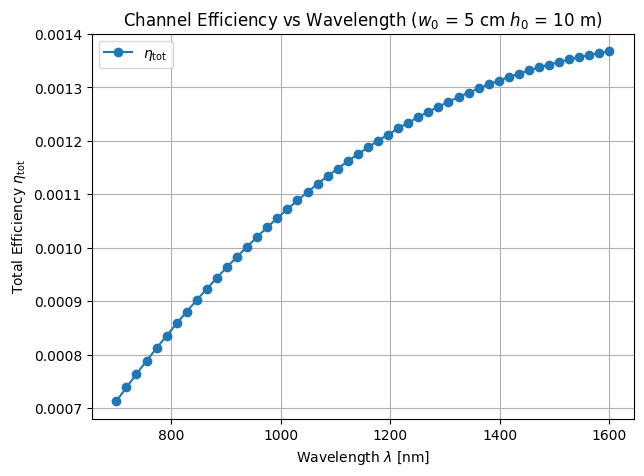

In [6]:
# Plotting total efficiency against wavelength
w0 = 0.05 # wavelength [m]
h0_ref = 10 # ground station heigh [m]
lam_values = np.linspace(700e-9, 1600e-9, 50)

# Slant distance taking into account the turbulence effect limited to the tropopause
L_atm = np.sqrt((RE + HT)**2 + (RE + h0_ref)**2 * (np.cos(zeta)**2 - 1)) - (RE + h0_ref) * np.cos(zeta)

eta_vals = []

for lam in lam_values:
    res = evaluate(lam, w0, h0_ref)
    wLT_tel = res["w_LT"]
    eta = eta_tot(res["gamma"], L_atm, aR, wLT_tel, b, eta_QE, res["r0"])
    eta_vals.append(eta)

# Plot
plt.figure(figsize=(7,5))
plt.plot(lam_values*1e9, eta_vals, 'o-', label=r'$\eta_{\mathrm{tot}}$')
plt.xlabel(r"Wavelength $\lambda$ [nm]")
plt.ylabel(r"Total Efficiency $\eta_{\mathrm{tot}}$")
plt.title(r"Channel Efficiency vs Wavelength ($w_0$ = 5 cm $h_0$ = 10 m)")
plt.legend()
plt.grid()
plt.show()

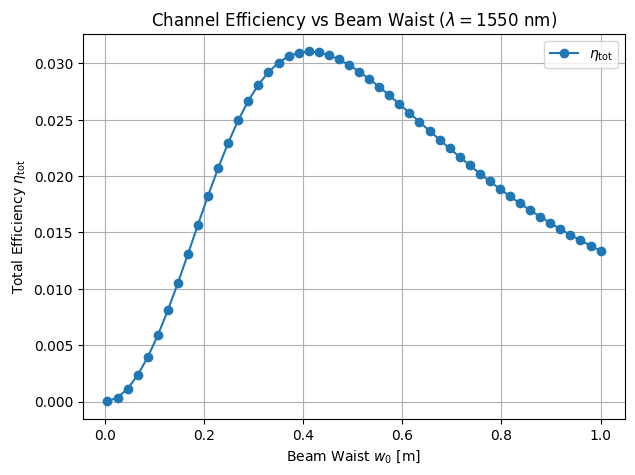

In [7]:
# Plotting total efficiency against initiam beam waist
lam = 1550e-9 # wavelength [m]
h0_ref = 10 # ground station heigh [m]
w0_values = np.linspace(0.005, 1, 50)
L_atm = np.sqrt((RE + HT)**2 + (RE + h0_ref)**2 * (np.cos(zeta)**2 - 1)) - (RE + h0_ref) * np.cos(zeta)


eta_vals = []
for w0 in w0_values:
    res = evaluate(lam, w0, h0_ref)
    eta = eta_tot(res["gamma"], L_atm, aR, res["w_LT"], b, eta_QE, res["r0"])
    eta_vals.append(eta)


# Plot
plt.figure(figsize=(7,5))
plt.plot(w0_values, eta_vals, 'o-', label=r'$\eta_{\mathrm{tot}}$')
plt.xlabel(r"Beam Waist $w_0$ [m]")
plt.ylabel(r"Total Efficiency $\eta_{\mathrm{tot}}$")
plt.title(r"Channel Efficiency vs Beam Waist ($\lambda=1550$ nm)")
plt.legend()
plt.grid()
plt.show()

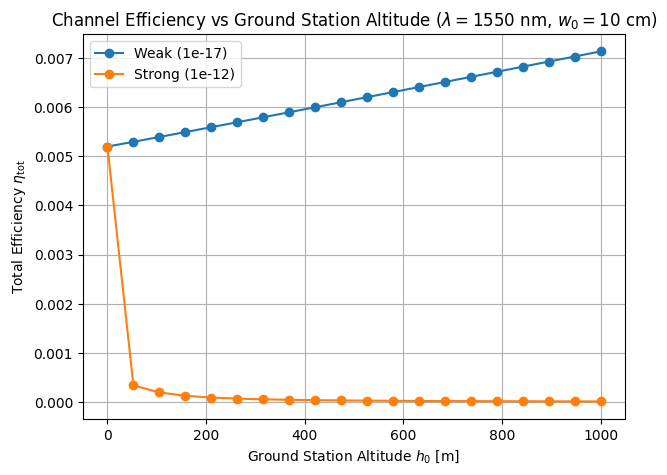

In [9]:
#!!WARNING!!: Running the plot blocks above after this one would give different reults as this block re-defines the baseline value of the refractive index structure parameter Cn2_h0.
# Make sure you run the parameters cell at the very beginning before you re-run the above plot blocks.
 
lam = 1550e-9
w0 = 0.1
h0_values = np.linspace(0, 1000, 20)
turbulence_cases = {"Weak (1e-17)": 1e-17, "Strong (1e-12)": 1e-12}

results = {}

for label, Cn2_h0 in turbulence_cases.items():
    eta_vals = []
    for h0 in h0_values:
        L_atm = np.sqrt((RE + HT)**2 + (RE + h0)**2 * (np.cos(zeta)**2 - 1)) - (RE + h0) * np.cos(zeta)
        res = evaluate(lam, w0, h0)
        eta = eta_tot(res["gamma"], L_atm, aR, res["w_LT"],
                      b, eta_QE, res["r0"])
        eta_vals.append(eta)
    results[label] = eta_vals


plt.figure(figsize=(7,5))
for label, vals in results.items():
    plt.plot(h0_values, vals, 'o-', label=label)
plt.xlabel(r"Ground Station Altitude $h_0$ [m]")
plt.ylabel(r"Total Efficiency $\eta_{\mathrm{tot}}$")
plt.title(r"Channel Efficiency vs Ground Station Altitude ($\lambda=1550$ nm, $w_0= 10$ cm)")
plt.legend()
plt.grid()
plt.show()
